In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
import re
from branca.colormap import LinearColormap
from haversine import haversine, Unit
from matplotlib.patches import Patch

## Pre processamento

In [2]:
def pre_processamento(file):
    df = pd.read_csv(f"./passagens/{file}")
    df = df[df['LAT'] != 0]
    df['LAT'] = df['LAT'] / 10000000
    df['LON'] = df['LON'] / 10000000
    
    df['ELAPSED_TIME_MIN'] = df['ELAPSED_TIME'] / 60000
    df['ELAPSED_TIME_S'] = df['ELAPSED_TIME'] / 1000
    
    df["TIMESTAMP_PC"] = (
        df["HOUR_PC"] * 3600 +
        df["MIN_PC"] * 60 +
        df["SEC_PC"] +
        df['CENT_PC'] / 100
    )
    
    df["TIMESTAMP_PC_UTC"] = df["TIMESTAMP_PC"] + 3 * 3600
    
    df["TIMESTAMP_GPS_UTC"] = (
        df["HOUR_GPS"] * 3600 +
        df["MIN_GPS"] * 60 +
        df["SEC_GPS"] +
        df["CENT_GPS"] / 100
    )

    # elapsed_time inicial (utc)
    init_timestmp = df["TIMESTAMP_PC_UTC"].iloc[0]
    init_elpsd = df["ELAPSED_TIME_S"].iloc[0]
    offset = init_timestmp - init_elpsd

    # timestamp_pc_utc - elapsed_time_utc
    df["LATENCIA_S"] = df["TIMESTAMP_PC_UTC"] - (offset + df["ELAPSED_TIME_S"])
    
    # normaliza pela latencia mais baixa
    lat_min = df["LATENCIA_S"].min()
    df["LATENCIA_S"] = df["LATENCIA_S"] - lat_min
    
    df["LATENCIA_MS"] = df["LATENCIA_S"] * 1000

    lat0 = df['LAT'].iloc[0]
    lon0 = df['LON'].iloc[0]

    df['DIST_M'] = df.apply(
        lambda row: haversine(
            (lat0, lon0),
            (row['LAT'], row['LON']),
            unit=Unit.METERS
        ),
        axis=1
    )
    
    df = df.reset_index(drop=True)

    first_package = df['PACKAGE'].iloc[0]
    df['PDR'] = (df.index + 1) / (df['PACKAGE'] - first_package + 1) * 100
    df['RSSI'] = - (256 - df["RSSI"])
    
    return df

## Graficos, mapas e tabelas

In [3]:
def max_dist(dfs):
    max_dist = 0
    for df in dfs:
        if df["DIST_M"].max() > max_dist:
            max_dist = df["DIST_M"].max()
            
    return max_dist

In [4]:
def max_rssi(dfs):
    max_rssi = -999
    for df in dfs:
        if df["RSSI"].max() > max_rssi:
            max_rssi = df["RSSI"].max()
            
    return max_rssi

def min_rssi(dfs):
    min_rssi = 999
    for df in dfs:
        if df["RSSI"].min() < min_rssi:
            min_rssi = df["RSSI"].min()
            
    return min_rssi

In [5]:
def mapa_HDOP(df, ar, sz, fr):
    colormapHDOP = LinearColormap(
        colors=['red', 'orange', 'green'],
        vmin=df['HDOP'].min(),
        vmax=df['HDOP'].max()
    )
    
    centro = [df['LAT'].mean(), df['LON'].mean()]
    mapa = folium.Map(location=centro, max_zoom=19, zoom_start=19, tiles=None)

    folium.TileLayer(
        'OpenStreetMap',
        name='Mapa',
        max_zoom=19
    ).add_to(mapa)

    folium.TileLayer(
        tiles='Esri.WorldImagery',
        name='Satélite',
        max_zoom=19
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)

    for _, row in df.iterrows():
        cor = colormapHDOP(row['HDOP'])

        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor,
            fill_opacity=0.5,
            opacity=0.5,
            popup=f"HDOP: {row['HDOP']}"
        ).add_to(mapa)

    # legenda
    colormapHDOP.caption = 'HDOP'
    colormapHDOP.add_to(mapa)

    mapa.save(f"./mapas/mapaHDOP_{ar}_{sz}_{fr}.html")

In [6]:
def mapa_RSSI(df, ar, sz, fr):
    colormapRSSI = LinearColormap(
        colors=['red', 'orange', 'green'],
        vmin=df['RSSI'].min(),
        vmax=df['RSSI'].max()
    )
    
    centro = [df['LAT'].mean(), df['LON'].mean()]
    mapa = folium.Map(location=centro, max_zoom=30, zoom_start=19, tiles=None)

    folium.TileLayer(
        'OpenStreetMap',
        name='Mapa',
        max_zoom=30
    ).add_to(mapa)

    folium.TileLayer(
        tiles='Esri.WorldImagery',
        name='Satélite',
        max_zoom=19
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)

    for _, row in df.iterrows():
        cor = colormapRSSI(row['RSSI'])

        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor,
            fill_opacity=0.5,
            opacity=0.5,
            popup=f"RSSI: {row['RSSI']} dBm"
        ).add_to(mapa)

    # legenda
    colormapRSSI.caption = 'RSSI (dBm)'
    colormapRSSI.add_to(mapa)

    mapa.save(f"./mapas/mapaRSSI_{ar}_{sz}_{fr}.html")

In [7]:
def mapa_latencia(df, ar, sz, fr):
    colormapLatencia = LinearColormap(
        colors=['green', 'orange', 'red'],
        vmin=df['LATENCIA_MS'].min(),
        vmax=df['LATENCIA_MS'].max()
    )
    
    centro = [df['LAT'].mean(), df['LON'].mean()]
    mapa = folium.Map(location=centro, max_zoom=19, zoom_start=19, tiles=None)

    folium.TileLayer(
        'OpenStreetMap',
        name='Mapa',
        max_zoom=19
    ).add_to(mapa)

    folium.TileLayer(
        tiles='Esri.WorldImagery',
        name='Satélite',
        max_zoom=19
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)

    for _, row in df.iterrows():
        cor = colormapLatencia(row['LATENCIA_MS'])

        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor,
            fill_opacity=0.5,
            opacity=0.5,
            popup=f"Latência: {row['LATENCIA_MS']} ms"
        ).add_to(mapa)

    # legenda
    colormapLatencia.caption = 'Latência (ms)'
    colormapLatencia.add_to(mapa)

    mapa.save(f"./mapas/mapaLatencia_{ar}_{sz}_{fr}.html")

In [8]:
def grafico_rssi(df, ar, sz, fr):
    plt.figure(figsize=(14,6))
    plt.plot(df['DIST_M'], df['RSSI'])
    plt.axis((
        0,
        df['DIST_M'].max(),
        df['RSSI'].min(),
        df['RSSI'].max()
    ))
    plt.xticks(rotation=45)
    plt.ylabel("RSSI")
    plt.xlabel("Distância (m)")
    plt.savefig(f"./graficos/graficoRSSI_{ar}_{sz}_{fr}")
    plt.show()

In [9]:
def grafico_rssi_boxplot(df, ar, sz, fr, passo=10):
    plt.figure(figsize=(14,6))
    
    max_dist = np.ceil(df['DIST_M'].max() / passo) * passo
    
    bins = np.arange(0, max_dist + passo, passo)
    
    labels = [f"0–{int(passo)}"] + [
        f"{int(i)}–{int(i+passo)}" for i in bins[1:-1]
    ]
    
    df['DIST_BIN'] = pd.cut(
        df['DIST_M'],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    grupos = [grupo['RSSI'].values for _, grupo in df.groupby('DIST_BIN', observed=True)]

    plt.boxplot(grupos, showfliers=True)
    
    plt.xticks(
        range(1, len(df['DIST_BIN'].unique()) + 1),
        df['DIST_BIN'].unique(),
        rotation=45
    )

    plt.ylabel("RSSI")
    plt.xlabel("Faixa de Distância (m)")

    plt.savefig(f"./graficos/graficoRSSI_boxplot_{ar}_{sz}_{fr}", bbox_inches="tight")
    plt.show()

In [10]:
def grafico_rssi_boxplot_multiplot(dfs, labels, passo=10):
    plt.figure(figsize=(16,6))

    cores = plt.cm.tab10.colors[:len(dfs)]

    # bins globais
    max_dist = max(df['DIST_M'].max() for df in dfs)
    max_dist = np.ceil(max_dist / passo) * passo
    bins = np.arange(0, max_dist + passo, passo)

    bin_labels = [
        f"{int(bins[i])}–{int(bins[i+1])}"
        for i in range(len(bins) - 1)
    ]

    largura = 0.8 / len(dfs)
    pos_base = np.arange(len(bin_labels))

    for i, (df, label, cor) in enumerate(zip(dfs, labels, cores)):
        df = df.copy()
        df['DIST_BIN'] = pd.cut(
            df['DIST_M'],
            bins=bins,
            labels=bin_labels,
            include_lowest=True
        )

        grupos = [
            df[df['DIST_BIN'] == b]['RSSI'].values
            for b in bin_labels
        ]

        posicoes = pos_base + i * largura

        bp = plt.boxplot(
            grupos,
            positions=posicoes,
            widths=largura,
            patch_artist=True,
            showfliers=False
        )

        for box in bp['boxes']:
            box.set_facecolor(cor)
            box.set_alpha(0.7)

        for med in bp['medians']:
            med.set_color("black")
            med.set_linewidth(1.2)

    # rotulo no centro
    centro = pos_base + largura * (len(dfs) - 1) / 2
    plt.xticks(centro, bin_labels, rotation=45)

    plt.xlabel("Faixa de Distância (m)")
    plt.ylabel("RSSI (dBm)")
    plt.grid(True, axis='y', alpha=0.3)

    # legenda manual
    legend_handles = [
        Patch(facecolor=cor, label=label, alpha=0.7)
        for cor, label in zip(cores, labels)
    ]
    plt.legend(handles=legend_handles, title="Configuração")

    plt.tight_layout()
    plt.savefig(f"./graficos/graficoRSSImult")
    plt.show()

In [11]:
def grafico_latencia(df, ar, sz, fr):
    plt.figure(figsize=(14,6))
    plt.plot(df['DIST_M'], df['LATENCIA_MS'])
    plt.xticks(rotation=45)
    plt.ylabel("Latência (ms)")
    plt.xlabel("Distância (m)")
    plt.savefig(f"./graficos/graficoLatencia_{ar}_{sz}_{fr}")
    plt.show()

In [12]:
def grafico_latencia_boxplot(df, ar, sz, fr, passo=10):
    plt.figure(figsize=(14,6))
    
    max_dist = np.ceil(df['DIST_M'].max() / passo) * passo
    
    bins = np.arange(0, max_dist + passo, passo)
    
    labels = [f"0–{int(passo)}"] + [
        f"{int(i)}–{int(i+passo)}" for i in bins[1:-1]
    ]
    
    df['DIST_BIN'] = pd.cut(
        df['DIST_M'],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    grupos = [grupo['LATENCIA_MS'].values for _, grupo in df.groupby('DIST_BIN', observed=True)]

    plt.boxplot(grupos, showfliers=True)
    
    plt.xticks(
        range(1, len(df['DIST_BIN'].unique()) + 1),
        df['DIST_BIN'].unique(),
        rotation=45
    )

    plt.ylabel("LATENCIA (ms)")
    plt.xlabel("Faixa de Distância (m)")

    plt.savefig(f"./graficos/graficoLatencia_boxplot_{ar}_{sz}_{fr}", bbox_inches="tight")
    plt.show()

In [13]:
def grafico_latencia_multiplot(dfs, labels, passo=10):
    plt.figure(figsize=(14,6))
    
    max_dist = max(df['DIST_M'].max() for df in dfs)
    max_dist = np.ceil(max_dist / passo) * passo
    
    bins = np.arange(0, max_dist + passo, passo)
    
    bin_labels = [f"0–{int(passo)}"] + [
        f"{int(i)}–{int(i+passo)}" for i in bins[1:-1]
    ]

    for df, label in zip(dfs, labels):
        df = df.copy()
        df['DIST_BIN'] = pd.cut(
            df['DIST_M'],
            bins=bins,
            labels=bin_labels,
            include_lowest=True
        )

        lat_media = (
            df.groupby('DIST_BIN', observed=True)['LATENCIA_MS']
            .mean()
        )

        plt.plot(
            lat_media.index.astype(str),
            lat_media.values,
            marker='o',
            label=label
        )

    plt.xlabel("Faixa de Distância (m)")
    plt.ylabel("Latência média (ms)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"./graficos/graficoLatenciamult")
    plt.tight_layout()

In [14]:
def grafico_pdr(df, ar, sz, fr):
    plt.figure(figsize=(14,6))
    plt.plot(df['ELAPSED_TIME_MIN'], df['PDR'])
    plt.xticks(rotation=45)
    plt.ylabel("PDR (%)")
    plt.xlabel("Tempo (m)")
    plt.savefig(f"./graficos/graficoPdr_{ar}_{sz}_{fr}")
    plt.show()

In [15]:
def grafico_pdr_multiplot(dfs, labels):
    plt.figure(figsize=(14,6))

    for df, label in zip(dfs, labels):
        plt.plot(df['ELAPSED_TIME_MIN'], df['PDR'], label=label)

    plt.xlabel("Tempo (min)")
    plt.ylabel("PDR (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"./graficos/graficoPDRmult")
    plt.show()

In [16]:
def tabela_resumo_configuracoes(dfs, labels):
    linhas = []

    for df, label in zip(dfs, labels):
        linha = {
            'Air rate (Kbps)': float(re.sub(r'[^0-9.]', '', label.split(',')[0])),
            'Tamanho do pacote (bytes)': int(re.sub(r'\D', '', label.split(',')[1])),
            'Frequência de envio (Hz)': int(re.sub(r'[^0-9.]', '', label.split(',')[2])),
            'Latência média (ms)': df['LATENCIA_MS'].mean(),
            'Desvio padrão da latência (ms)': df['LATENCIA_MS'].std(),
            'RSSI médio (dBm)': df['RSSI'].mean(),
            'Desvio padrão do RSSI (dBm)': df['RSSI'].std(),
            'PDR (%)': df['PDR'].mean(),
            'Número de pacotes': len(df)
        }

        linhas.append(linha)

    tabela = pd.DataFrame(linhas)
    
    tabela = tabela.rename(columns={
        'Air rate (Kbps)': r'\makecell{Air rate\\(Kbps)}',
        'Tamanho do pacote (bytes)': r'\makecell{Tamanho do\\pacote (bytes)}',
        'Frequência de envio (Hz)': r'\makecell{Frequência de\\envio (Hz)}',
        'Latência média (ms)': r'\makecell{Latência\\média (ms)}',
        'Desvio padrão da latência (ms)': r'\makecell{Desvio padrão\\da latência (ms)}',
        'RSSI médio (dBm)': r'\makecell{RSSI médio\\(dBm)}',
        'Desvio padrão do RSSI (dBm)': r'\makecell{Desvio padrão\\do RSSI (dBm)}',
        'PDR (%)': r'\makecell{PDR\\(\%)}',
        'Número de pacotes': r'\makecell{Número de\\pacotes}'
    })

    return tabela.round({
        'Latência média (ms)': 2,
        'Desvio padrão da latência (ms)': 2,
        'RSSI médio (dBm)': 1,
        'Desvio padrão do RSSI (dBm)': 1,
        'PDR (%)': 2
    })


In [17]:
dfs = []

## Primeira configuração
Air Rate: 2.4 Kbps

Tamanho: 64 bytes

Frequência de envio: 1 Hz

In [18]:
df_24_64 = pre_processamento("leitura_serial_105559_2_4_64_1000.csv")
ar = 24
sz = 64
fr = 1
dfs.append(df_24_64)

In [19]:
mapa_HDOP(df_24_64, ar, sz, fr)
mapa_RSSI(df_24_64, ar, sz, fr)
mapa_latencia(df_24_64, ar, sz, fr)

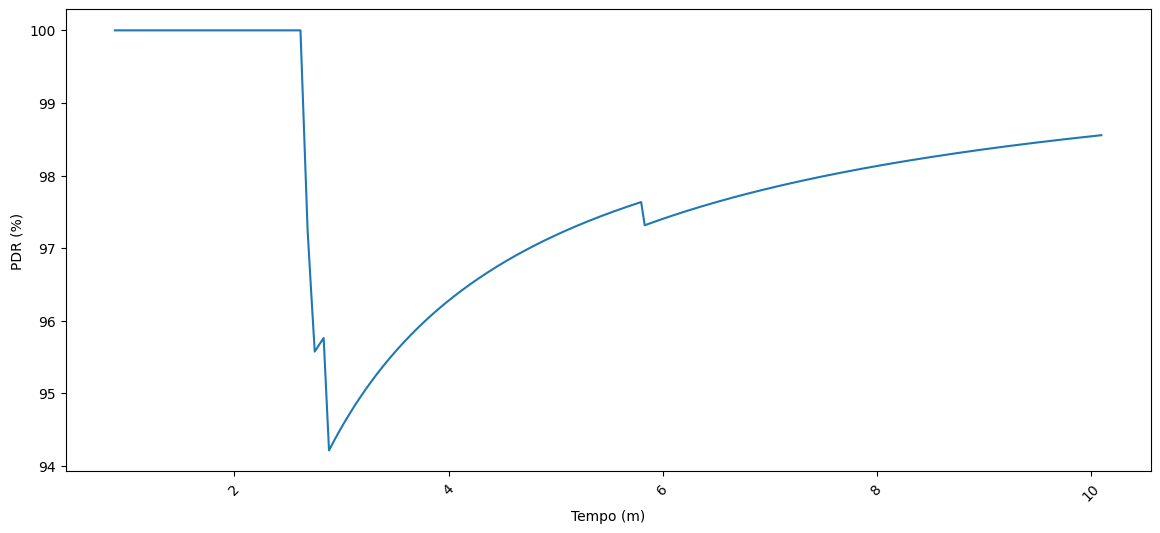

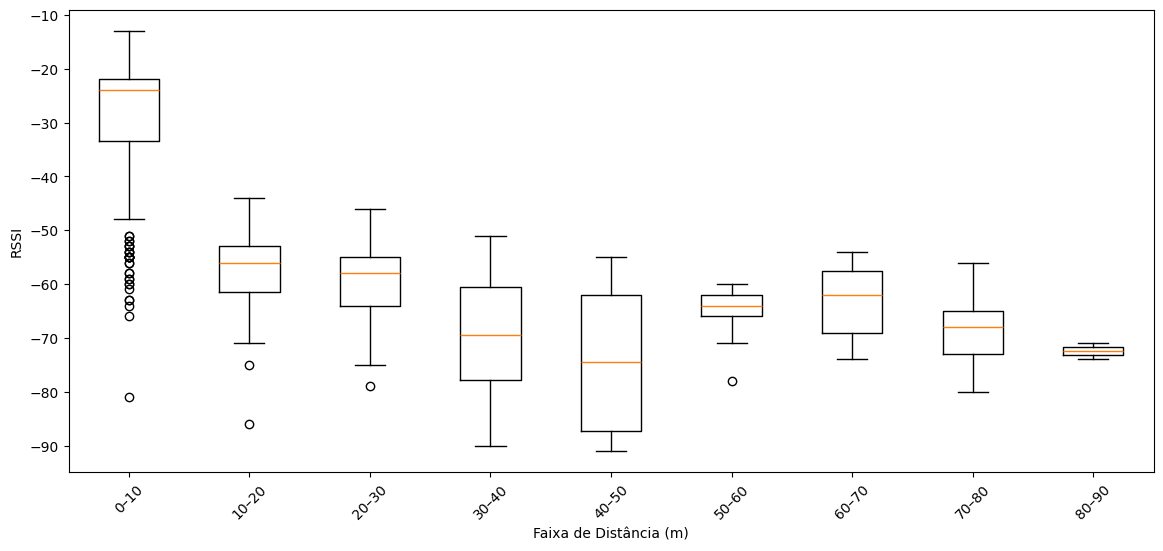

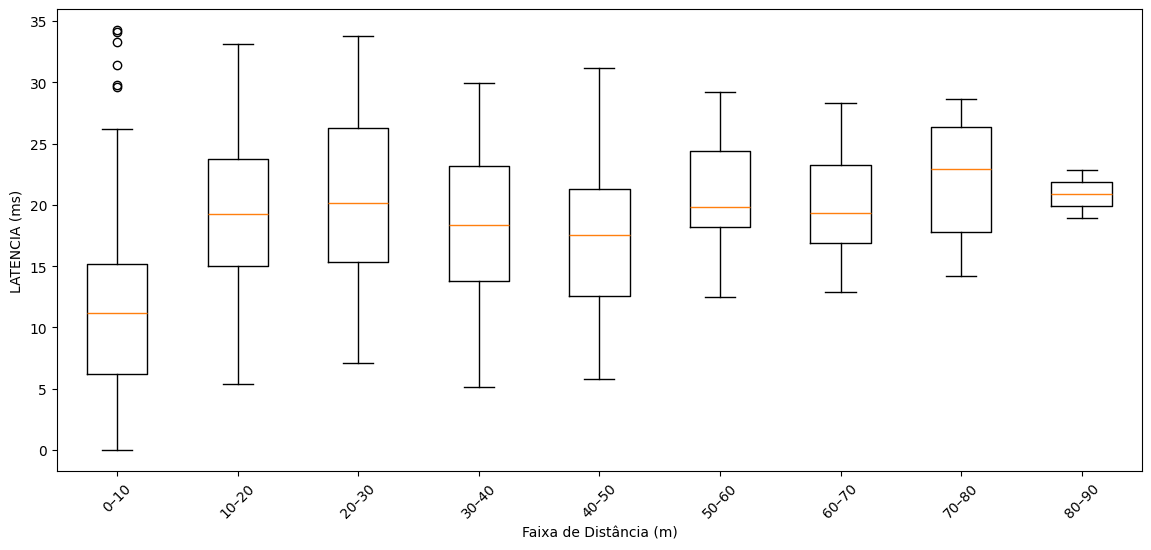

In [20]:
grafico_pdr(df_24_64, ar, sz, fr)
grafico_rssi_boxplot(df_24_64, ar, sz, fr)
grafico_latencia_boxplot(df_24_64, ar, sz, fr)

## Segunda configuração
Air Rate: 2.4 Kbps

Tamanho: 128 bytes

Frequência de envio: 1 Hz

In [21]:
df_24_128 = pre_processamento("leitura_serial_123346_2_4_128_1000.csv")
ar = 24
sz = 128
fr = 1
dfs.append(df_24_128)

In [22]:
mapa_HDOP(df_24_128, ar, sz, fr)
mapa_RSSI(df_24_128, ar, sz, fr)
mapa_latencia(df_24_128, ar, sz, fr)

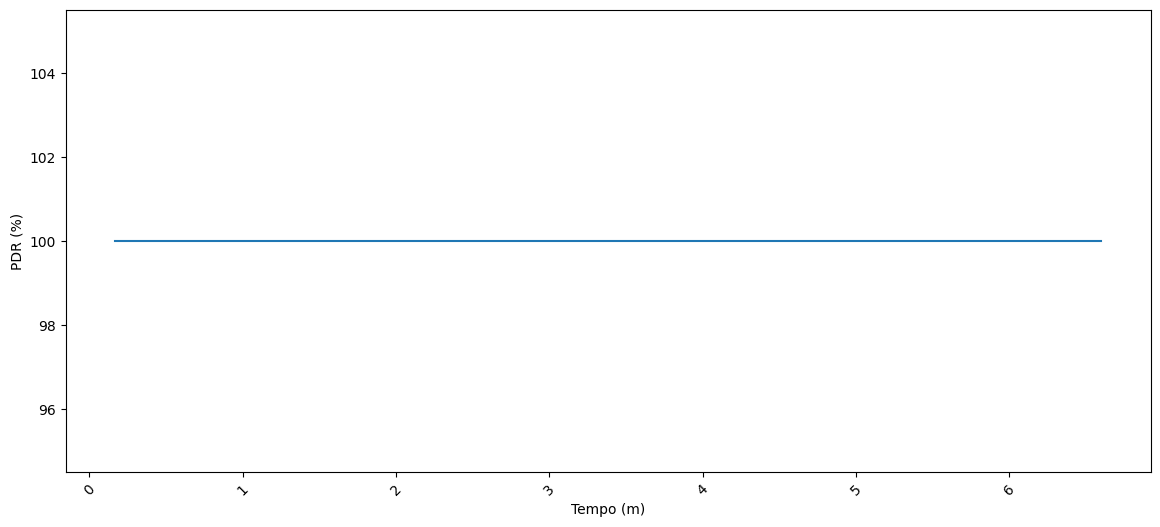

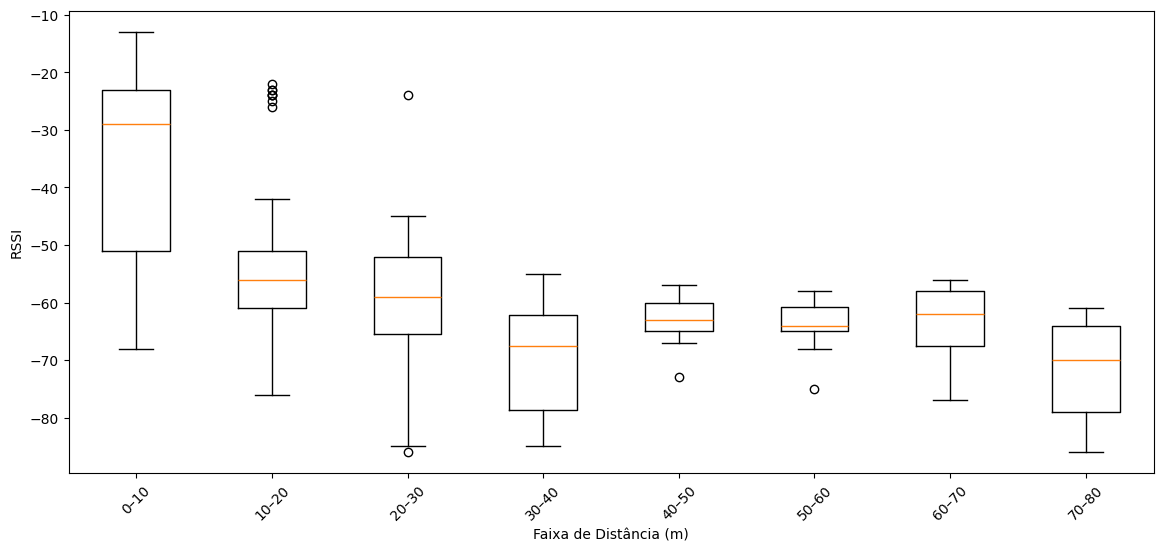

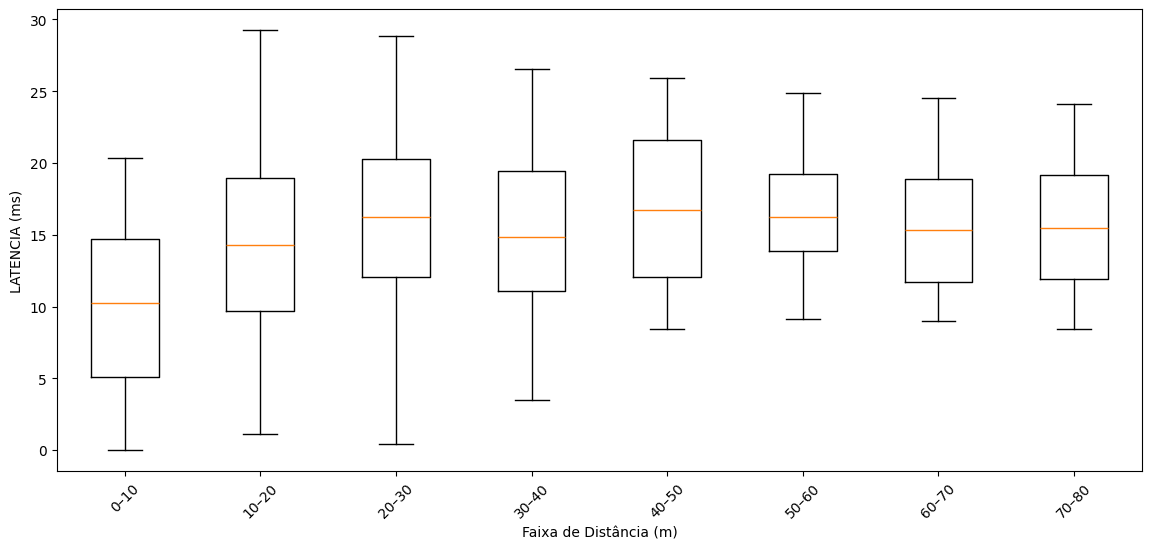

In [23]:
grafico_pdr(df_24_128, ar, sz, fr)
grafico_rssi_boxplot(df_24_128, ar, sz, fr)
grafico_latencia_boxplot(df_24_128, ar, sz, fr)

## Terceira configuração
Air Rate: 4.8 Kbps

Tamanho: 64 bytes

Frequência de envio: 1 Hz

In [24]:
df_48_64 = pre_processamento("leitura_serial_111351_4_8_64_1000.csv")
ar = 48
sz = 64
fr = 1
dfs.append(df_48_64)

In [25]:
mapa_HDOP(df_48_64, ar, sz, fr)
mapa_RSSI(df_48_64, ar, sz, fr)
mapa_latencia(df_48_64, ar, sz, fr)

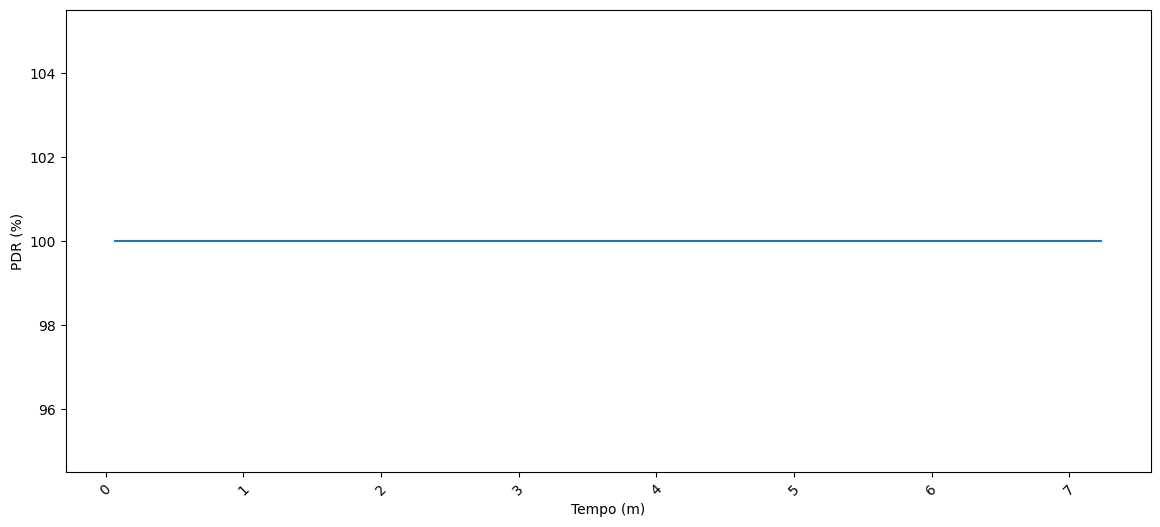

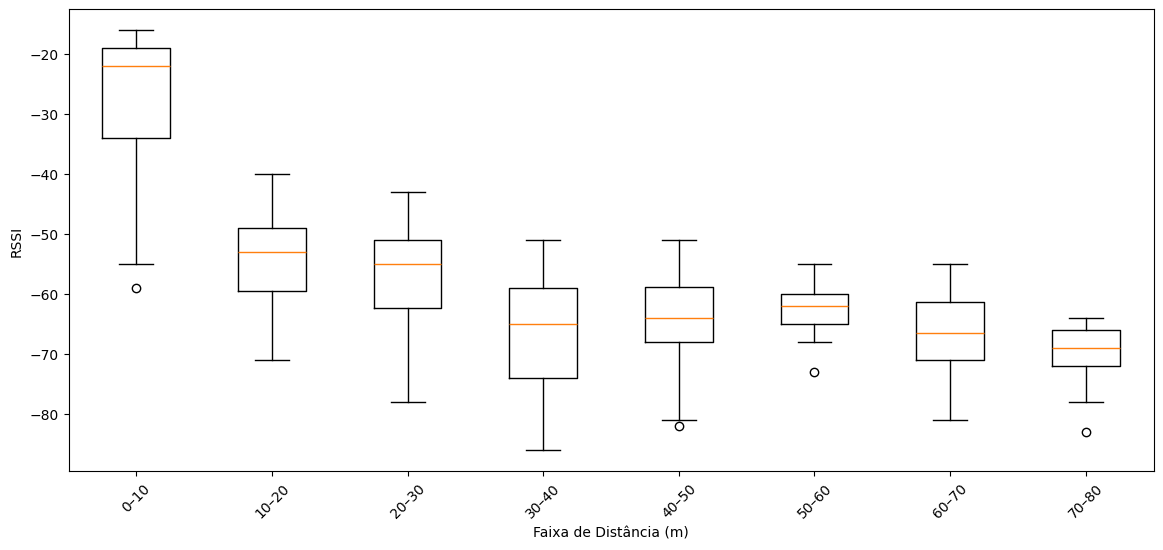

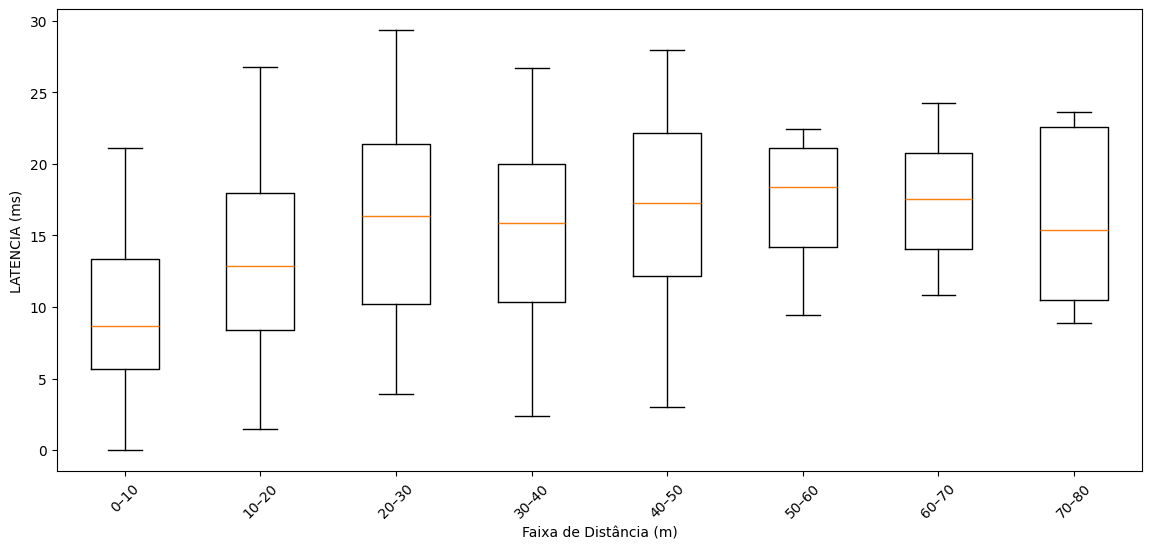

In [26]:
grafico_pdr(df_48_64, ar, sz, fr)
grafico_rssi_boxplot(df_48_64, ar, sz, fr)
grafico_latencia_boxplot(df_48_64, ar, sz, fr)

## Quarta configuração
Air Rate: 4.8 Kbps

Tamanho: 128 bytes

Frequência de envio: 1 Hz

In [27]:
df_48_128_1 = pre_processamento("leitura_serial_125548_4_8_128_1000.csv")
ar = 48
sz = 128
fr = 1
dfs.append(df_48_128_1)

In [28]:
mapa_HDOP(df_48_128_1, ar, sz, fr)
mapa_RSSI(df_48_128_1, ar, sz, fr)
mapa_latencia(df_48_128_1, ar, sz, fr)

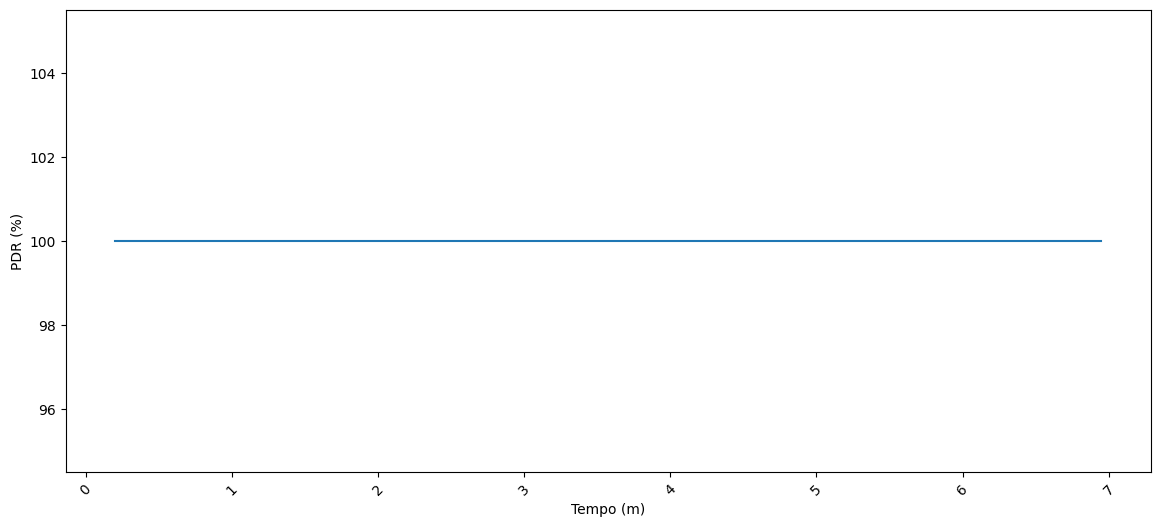

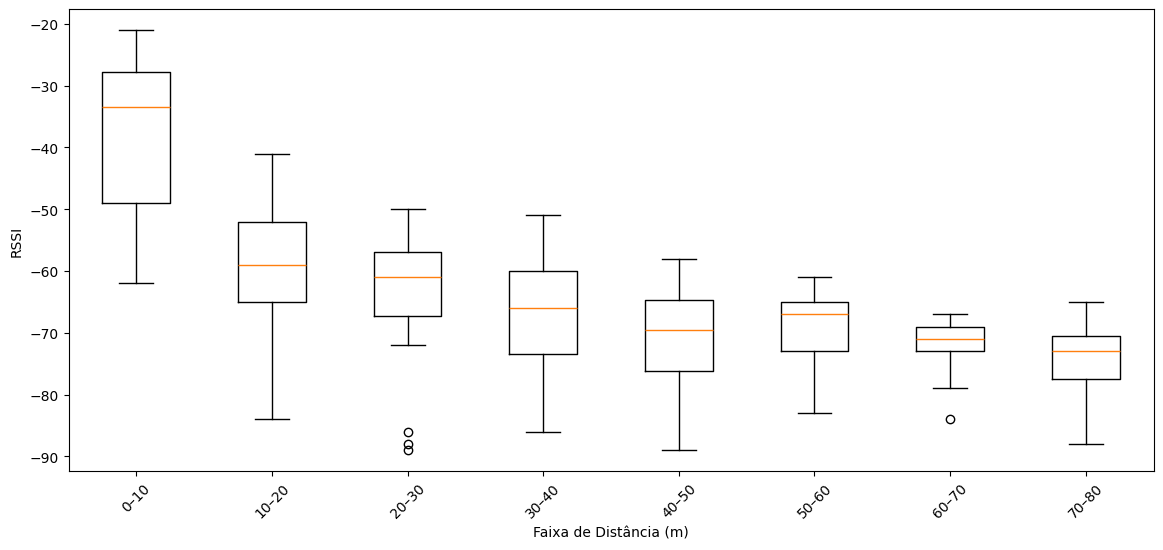

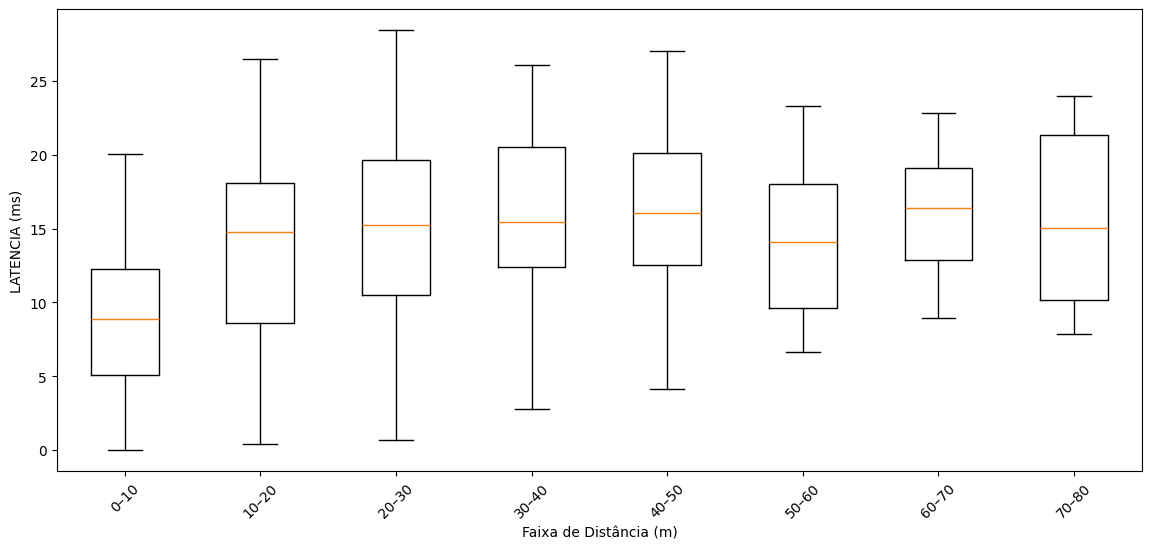

In [29]:
grafico_pdr(df_48_128_1, ar, sz, fr)
grafico_rssi_boxplot(df_48_128_1, ar, sz, fr)
grafico_latencia_boxplot(df_48_128_1, ar, sz, fr)

## Quinta configuração
Air Rate: 4.8 Kbps

Tamanho: 128 bytes

Frequência de envio: 2 Hz

In [30]:
df_48_128_2 = pre_processamento("leitura_serial_130843_4_8_128_500.csv")
ar = 48
sz = 128
fr = 2
dfs.append(df_48_128_2)

In [31]:
mapa_HDOP(df_48_128_2, ar, sz, fr)
mapa_RSSI(df_48_128_2, ar, sz, fr)
mapa_latencia(df_48_128_2, ar, sz, fr)

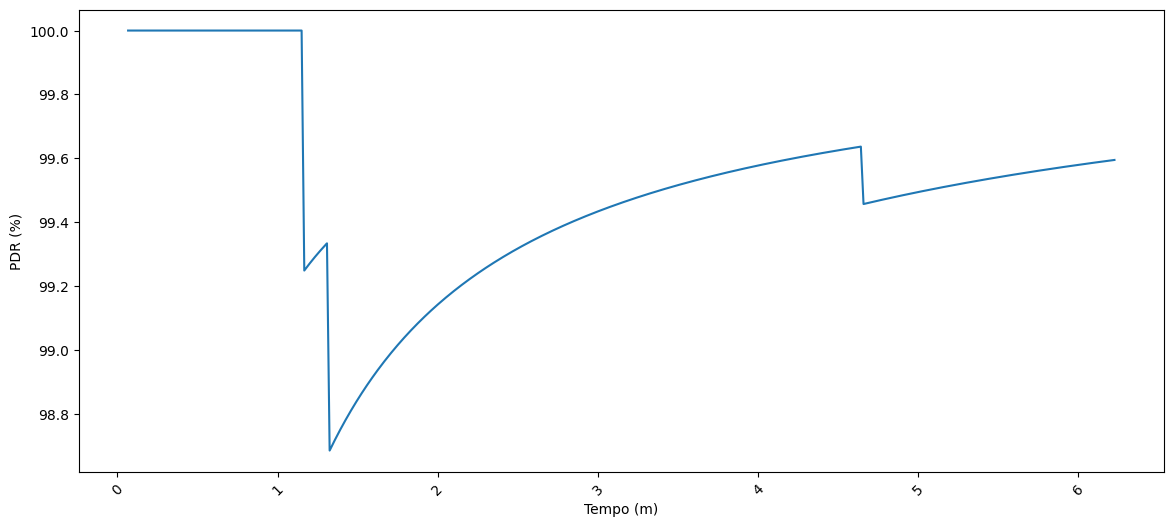

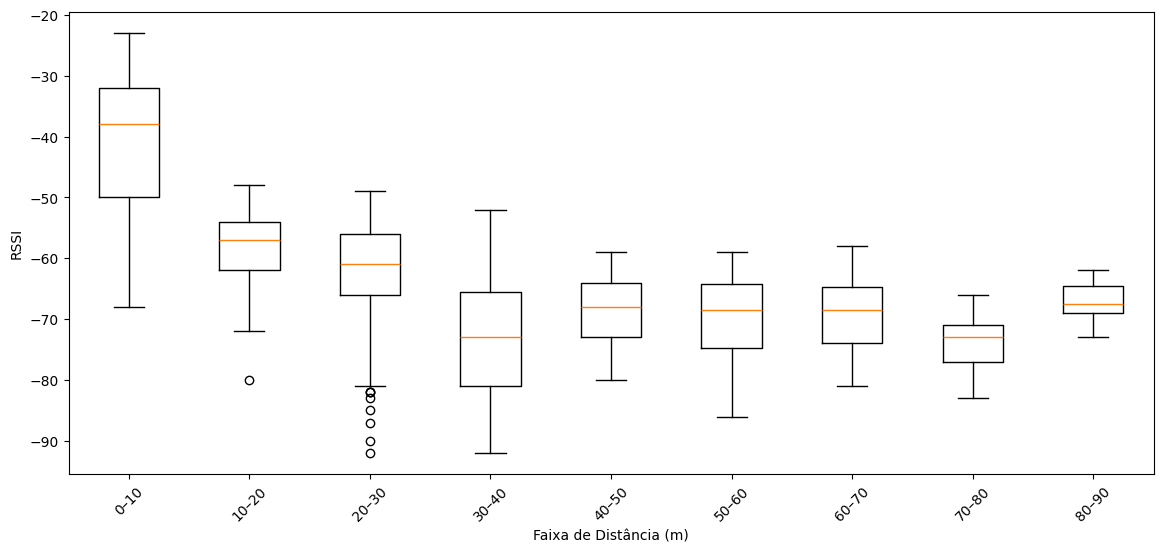

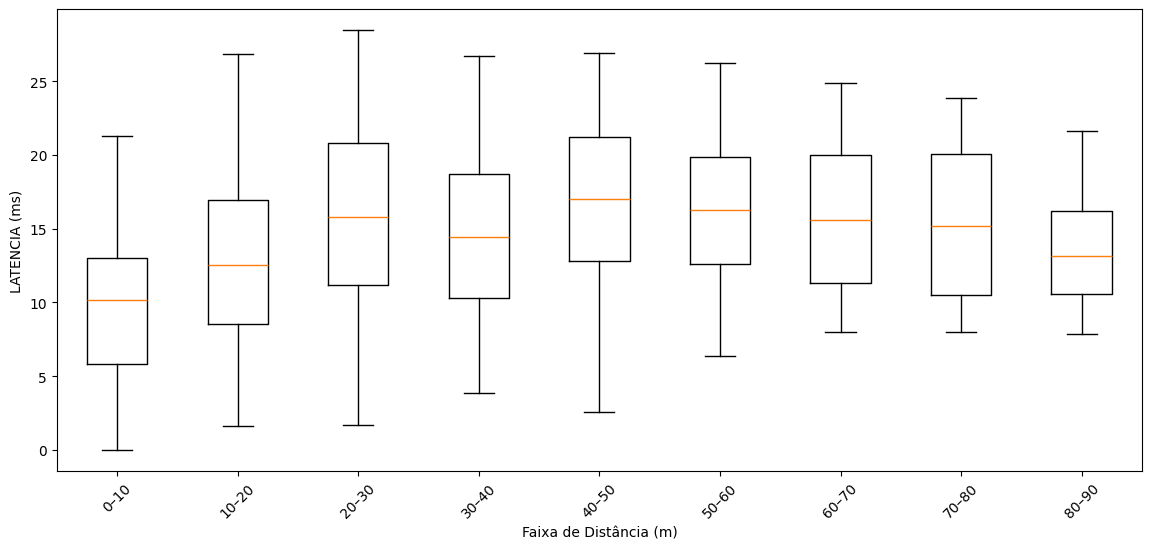

In [32]:
grafico_pdr(df_48_128_2, ar, sz, fr)
grafico_rssi_boxplot(df_48_128_2, ar, sz, fr)
grafico_latencia_boxplot(df_48_128_2, ar, sz, fr)

## Sexta configuração
Air Rate: 4.8 Kbps

Tamanho: 200 bytes

Frequência de envio: 2 Hz

In [33]:
df_48_200_2 = pre_processamento("leitura_serial_120541_4_8_200_500.csv")
ar = 48
sz = 200
fr = 2
dfs.append(df_48_200_2)

In [34]:
mapa_HDOP(df_48_200_2, ar, sz, fr)
mapa_RSSI(df_48_200_2, ar, sz, fr)
mapa_latencia(df_48_200_2, ar, sz, fr)

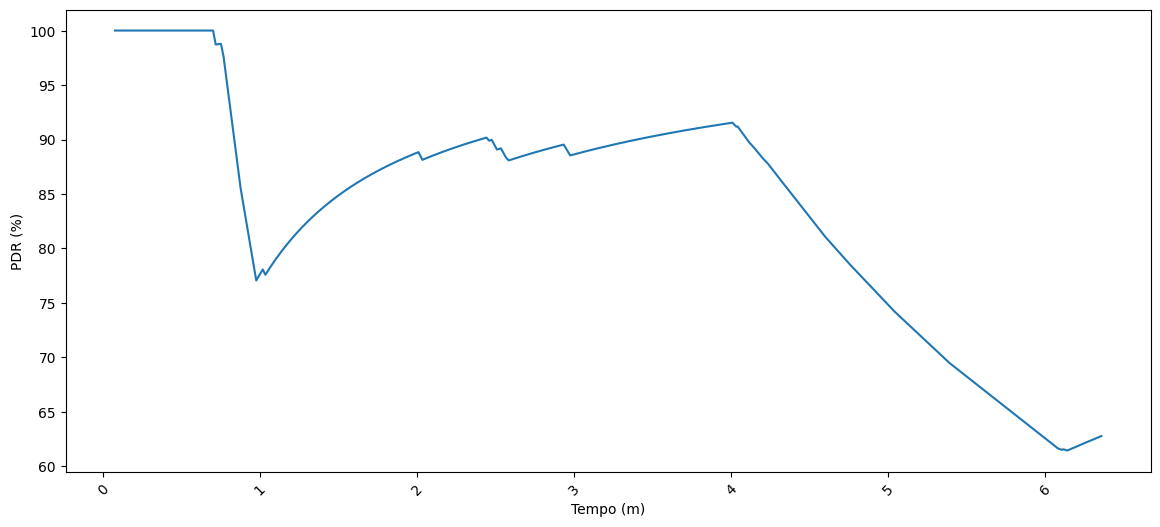

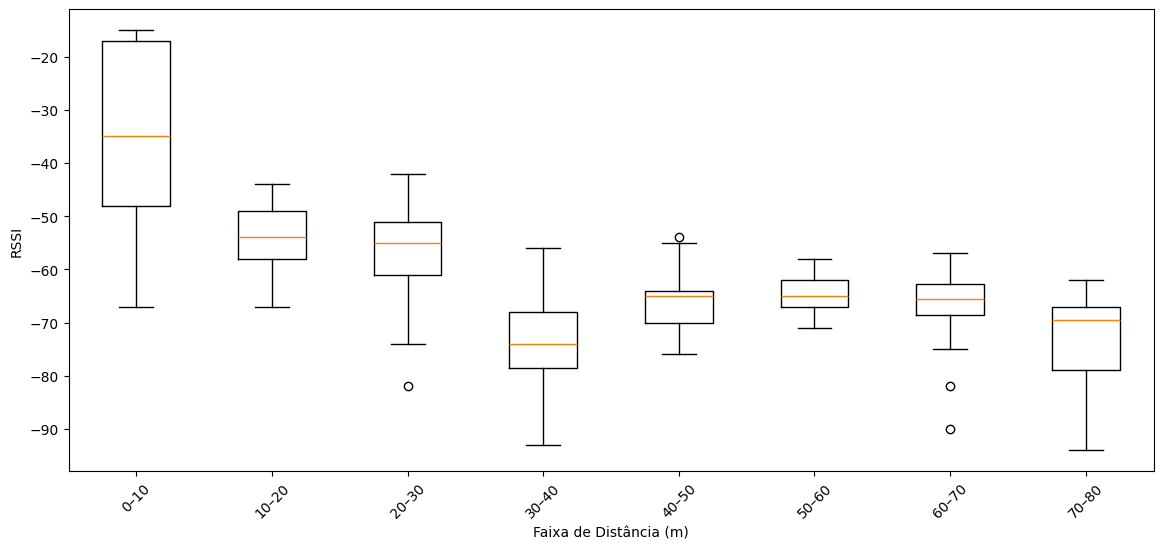

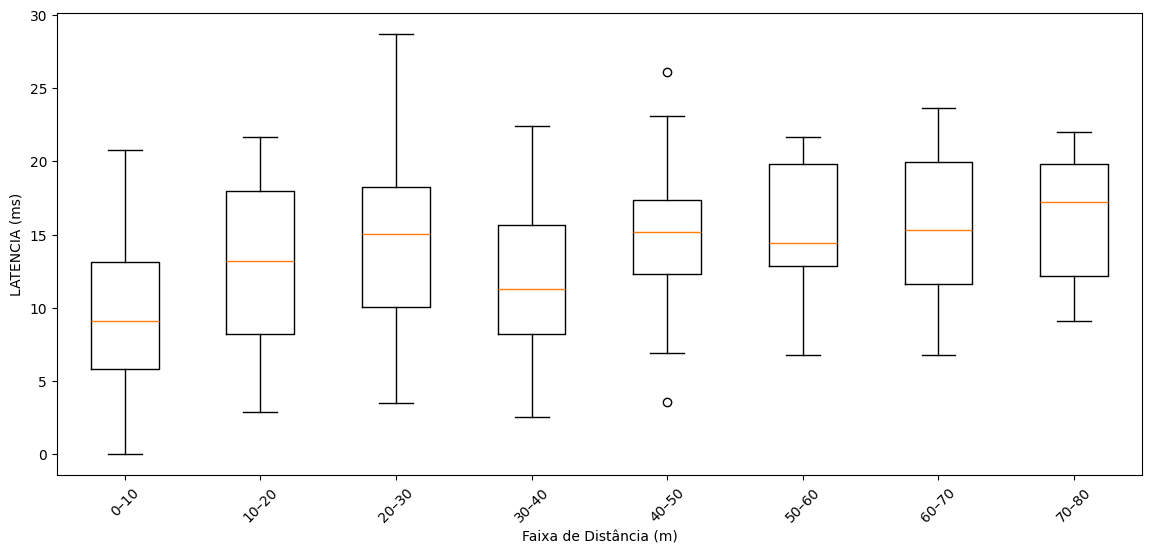

In [35]:
grafico_pdr(df_48_200_2, ar, sz, fr)
grafico_rssi_boxplot(df_48_200_2, ar, sz, fr)
grafico_latencia_boxplot(df_48_200_2, ar, sz, fr)

# Comparação

In [36]:
labels = ["2.4 Kbps, 64 bytes, 1 Hz",
          "2.4 Kbps, 128 bytes, 1 Hz",
          "4.8 Kbps, 64 bytes, 1 Hz",
          "4.8 Kbps, 128 bytes, 1 Hz",
          "4.8 Kbps, 128 bytes, 2 Hz",
          "4.8 Kbps, 200 bytes, 2 Hz"]

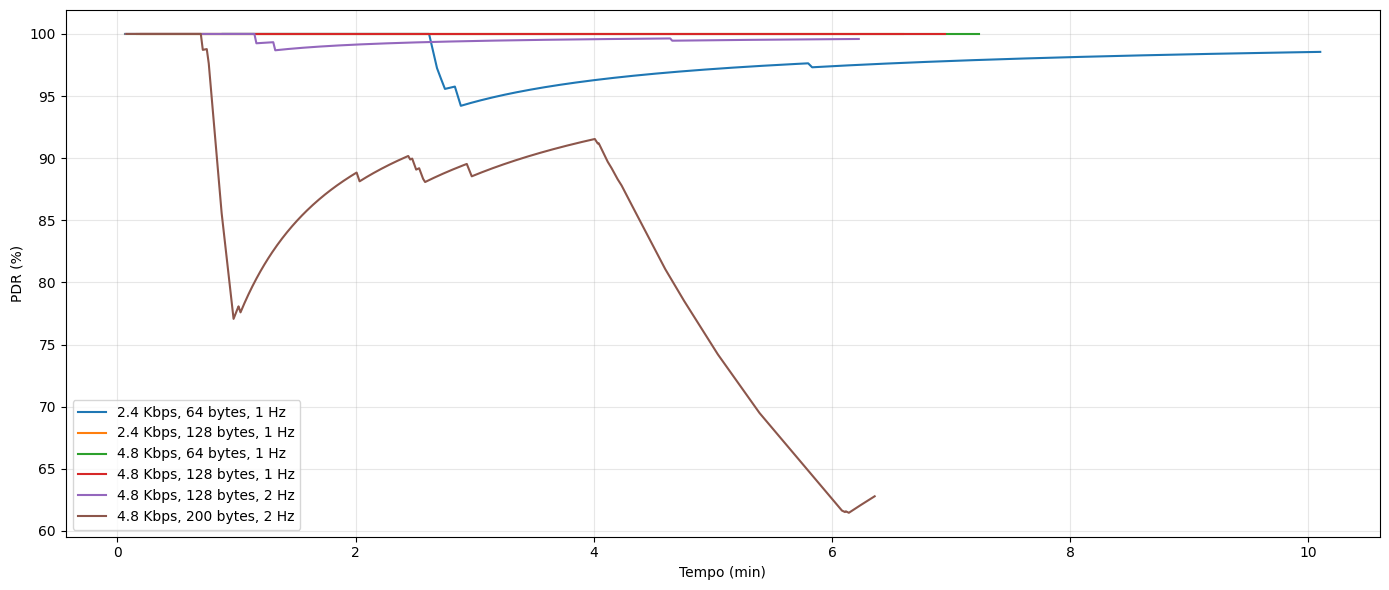

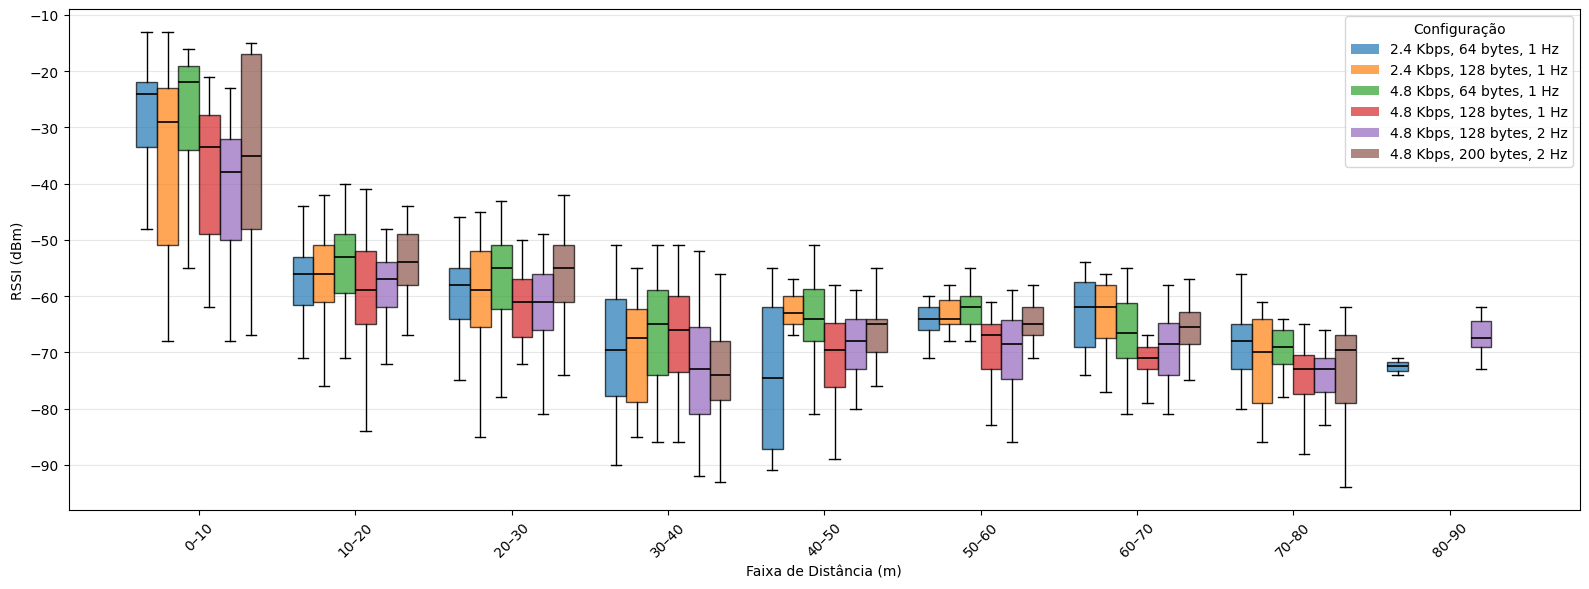

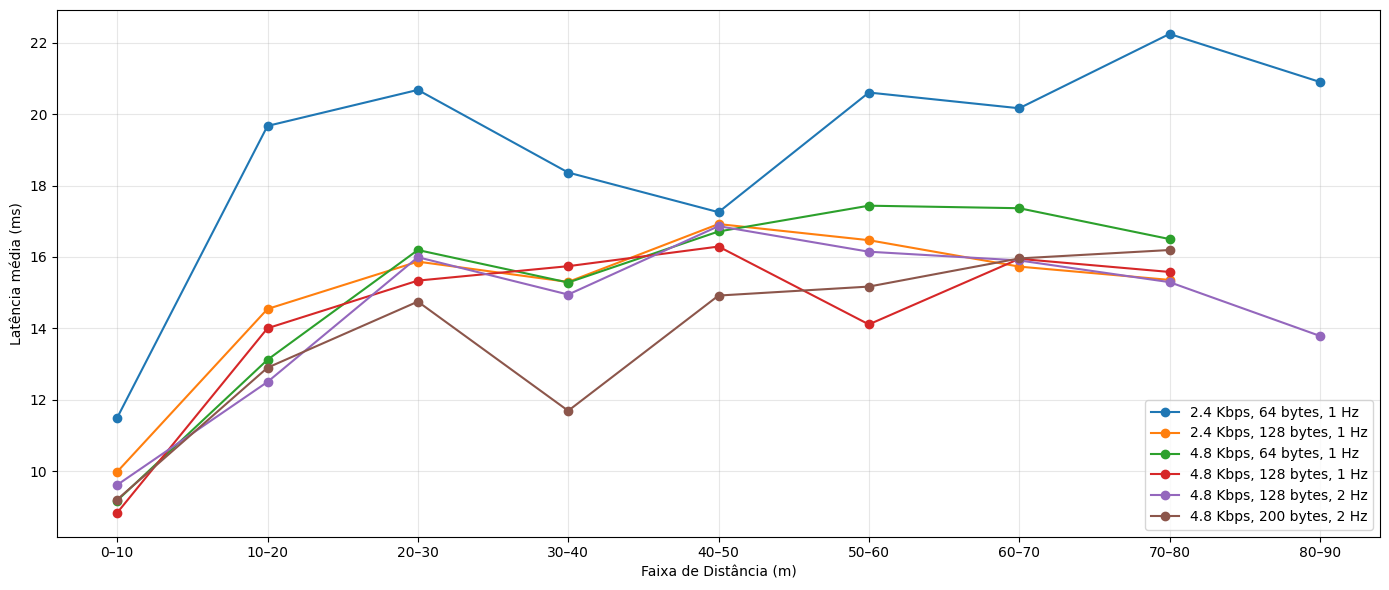

In [37]:
grafico_pdr_multiplot(dfs, labels)
grafico_rssi_boxplot_multiplot(dfs, labels, 10)
grafico_latencia_multiplot(dfs, labels, 10)

In [38]:
tabela = tabela_resumo_configuracoes(dfs, labels)
tabela

,\makecell{Air rate\\(Kbps)},\makecell{Tamanho do\\pacote (bytes)},\makecell{Frequência de\\envio (Hz)},\makecell{Latência\\média (ms)},\makecell{Desvio padrão\\da latência (ms)},\makecell{RSSI médio\\(dBm)},\makecell{Desvio padrão\\do RSSI (dBm)},\makecell{PDR\\(\%)},\makecell{Número de\\pacotes}
0,2.4,64,1,17.192075,7.498536,-55.536630,19.469749,97.874114,546
1,2.4,128,1,14.544295,6.179954,-57.490956,15.154534,100.000000,387
2,4.8,64,1,14.317285,6.760735,-53.772622,17.101592,100.000000,431
3,4.8,128,1,14.429998,6.381794,-61.625616,13.406014,100.000000,406
4,4.8,128,2,14.644296,6.124732,-63.108548,12.975485,99.512631,737
5,4.8,200,2,13.201989,5.696392,-57.578059,16.111242,88.123643,474


In [39]:
print(
    tabela.to_latex(
        index=False,
        caption="Resumo estatístico das configurações LoRa",
        label="tab:resumo_lora",
        escape=False
    )
)

\begin{table}
\caption{Resumo estatístico das configurações LoRa}
\label{tab:resumo_lora}
\begin{tabular}{rrrrrrrrr}
\toprule
\makecell{Air rate\\(Kbps)} & \makecell{Tamanho do\\pacote (bytes)} & \makecell{Frequência de\\envio (Hz)} & \makecell{Latência\\média (ms)} & \makecell{Desvio padrão\\da latência (ms)} & \makecell{RSSI médio\\(dBm)} & \makecell{Desvio padrão\\do RSSI (dBm)} & \makecell{PDR\\(\%)} & \makecell{Número de\\pacotes} \\
\midrule
2.400000 & 64 & 1 & 17.192075 & 7.498536 & -55.536630 & 19.469749 & 97.874114 & 546 \\
2.400000 & 128 & 1 & 14.544295 & 6.179954 & -57.490956 & 15.154534 & 100.000000 & 387 \\
4.800000 & 64 & 1 & 14.317285 & 6.760735 & -53.772622 & 17.101592 & 100.000000 & 431 \\
4.800000 & 128 & 1 & 14.429998 & 6.381794 & -61.625616 & 13.406014 & 100.000000 & 406 \\
4.800000 & 128 & 2 & 14.644296 & 6.124732 & -63.108548 & 12.975485 & 99.512631 & 737 \\
4.800000 & 200 & 2 & 13.201989 & 5.696392 & -57.578059 & 16.111242 & 88.123643 & 474 \\
\bottomrule
\end{ta

In [40]:
print(f"Distância máxima: {max_dist(dfs)}")
print(f"RSSI máximo: {max_rssi(dfs)}, RSSI min: {min_rssi(dfs)}")

Distância máxima: 81.22233482714745
RSSI máximo: -13, RSSI min: -94
